# Physicsl Models of Living Systems
## Homework 4
### Maryam Feizi - 2091504


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

#### Using non-homogeneous Poisson process, generate the spike train of 100 neurons (if your code is efficient you can also do more, e.g. 200 or 1000

#### Do this for two different situations (For both cases you can use a time step $dt = 0.01$. I remember you that the probability of a spike is $ \lambda_{t} dt $. Do at least 1000 timesteps):

#### 1) The firing rate $\lambda_{t}$ is independent for each neuron, and generated as random variables extracted each time step by an exponential distribution $ p(\lambda_{t}) =  r exp [- r \lambda_{t}] $ with $ r = 0.1 $. 

#### 2) The firing rate $\lambda_{t}$ is the same for each neuron, and generated as random variables extracted each time step by an exponential distribution $ p(\lambda_{t}) =  r exp [- r \lambda_{t}] $ with $ r = 0.1 $. 
#### What is the differences in terms of neural avalanches for the two cases? You can, if you want, characterize the avalanches size distributions, remembering that an avalanche size is defined the total number of neurons spiking between to period of total silence (no neurons spiking).

Let's define some general functions to tackle the following problems. Basically, we need a function whech returns an array with  given length of $ n $ which represents the number of time steps considered. The elements of the array will be zero and ones. One if the neuron fires in the time bin $ dt $ and zero if it does not.\
To do so, first we need to create a binary array, corresponding to a homogenous Poisson process. We simply create a numpy zeros array with length $ n $. As the number of spikes ( number of ones in the array) we draw a random number from a Poisson distribution, with a rate $ \lambda_{max} $ corresponding to the maximum possible rate of firing: 
$$
m \sim  \frac{(\lambda_{max})^m}{m!}e^{-\lambda_{max}}
$$

Note that for simplicity I have set the total trial length $ T $ to 1. So using $ m $ as the number of spikes in the train, we will uniformly generate m numbers between  0 and n, which represent the time bin which correspond to the spike. 

So far we have created a homogenous Poisson process. To make it inhomogenous, we look at non-zero elements again. First we draw a random number from the given exponential distribution, as $ \lambda_{t} $:

$$
\lambda_{t} \sim  r e ^{- r \lambda_{t}}
$$

Then another random number between 0 and 1: $ u(0, 1) $. Next if the below inequality holds, we set the element value back to zero:

$$
\frac{\lambda_{t}}{\lambda_{max}} < u(0,1)
$$

Let's implement the functions and rules that I mentioned above. First I define a "spike probability train" generator, which is simply a function which returns an array of probabilities for a spike in each time step. The distribution of spikes follow an non-homogenous Poisson distribution. Then define two different function for firing rate.

In [83]:
def non_homogeneous_poisson_process(time, lambda_t):
    dt = time[1] - time[0]
    
    spikes = np.random.poisson(lambda_t * dt)
    spike_train = np.where(spikes > 0)[0]
    
    return spike_train

In [84]:
def firing_rate_function_independent(t, num_neurons, r=0.1):
    lambda_t = np.random.exponential(scale=1/(r), size=(num_neurons, len(t)))
    return lambda_t

def firing_rate_function_shared(t, num_neurons, r=0.1):
    lambda_t = np.random.exponential(scale=1/(r), size=len(t))
    return np.tile(lambda_t, (num_neurons, 1))



First I visualized two diffrent firing rate spikes to see the difference.

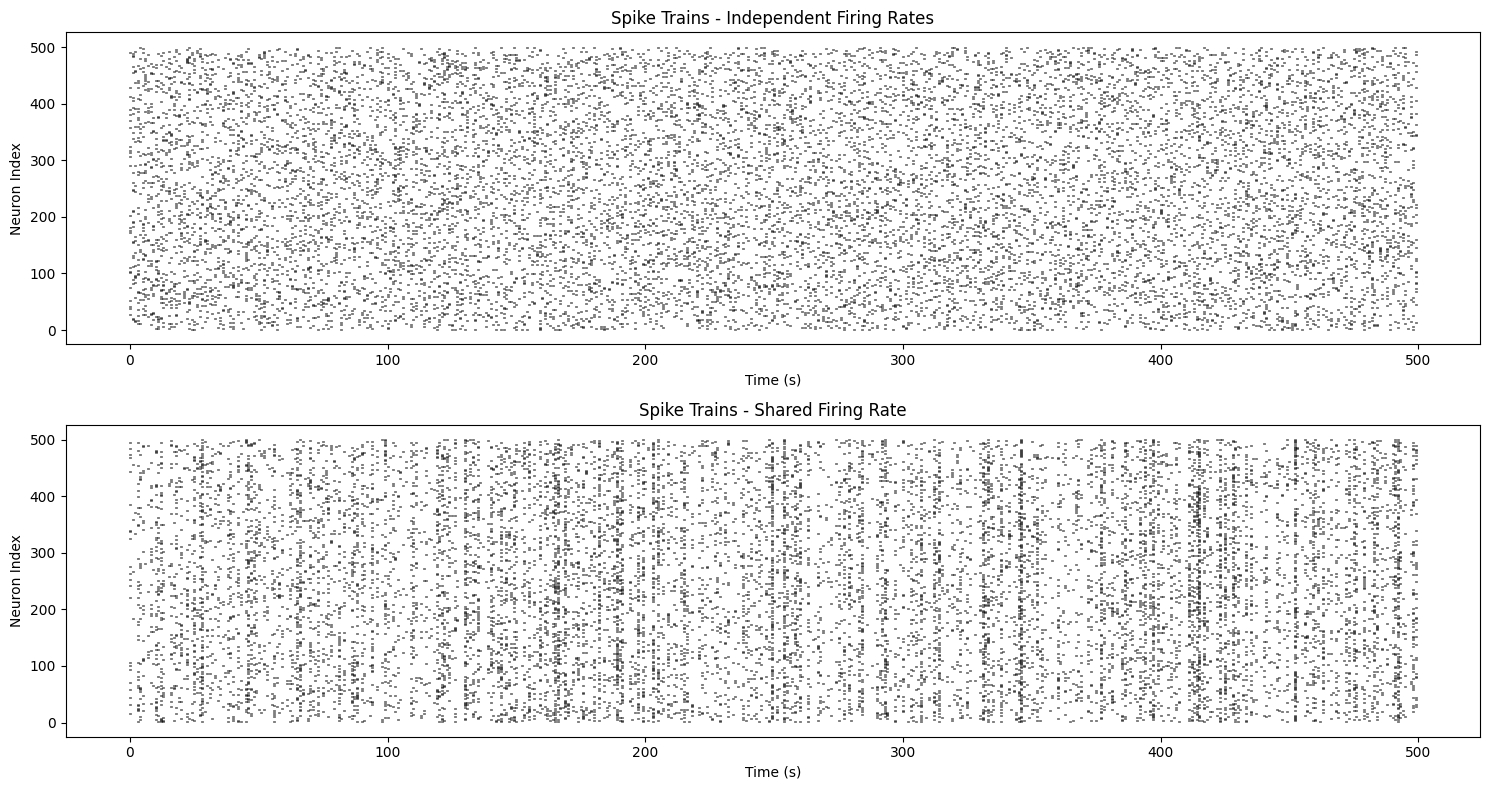

In [138]:
num_neurons = 500
time = np.arange(0, 5, 0.01)  #  0.01s time resolution

# For independent firing rates
firing_rates_independent = firing_rate_function_independent(time, num_neurons)

# For shared firing rate
firing_rate_shared = firing_rate_function_shared(time, num_neurons)

# Generate spike trains for number of neurons with independent firing rates
spike_trains_independent = [non_homogeneous_poisson_process(time, firing_rates_independent[i]) for i in range(num_neurons)]

# Generate spike trains for neurons with shared firing rate
spike_trains_shared = [non_homogeneous_poisson_process(time, firing_rate_shared[i]) for i in range(num_neurons)]

# Plot the spike trains for independent firing rates
plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
for i in range(num_neurons):
    plt.eventplot(spike_trains_independent[i], lineoffsets=i + 1, color='black', linewidths=2)

plt.title('Spike Trains - Independent Firing Rates')
plt.xlabel('Time (s)')
plt.ylabel('Neuron Index')

# Plot the spike trains for shared firing rate
plt.subplot(2, 1, 2)
for i in range(num_neurons):
    plt.eventplot(spike_trains_shared[i], lineoffsets=i + 1, color='black', linewidths=2)

plt.title('Spike Trains - Shared Firing Rate')
plt.xlabel('Time (s)')
plt.ylabel('Neuron Index')

plt.tight_layout()
plt.show()


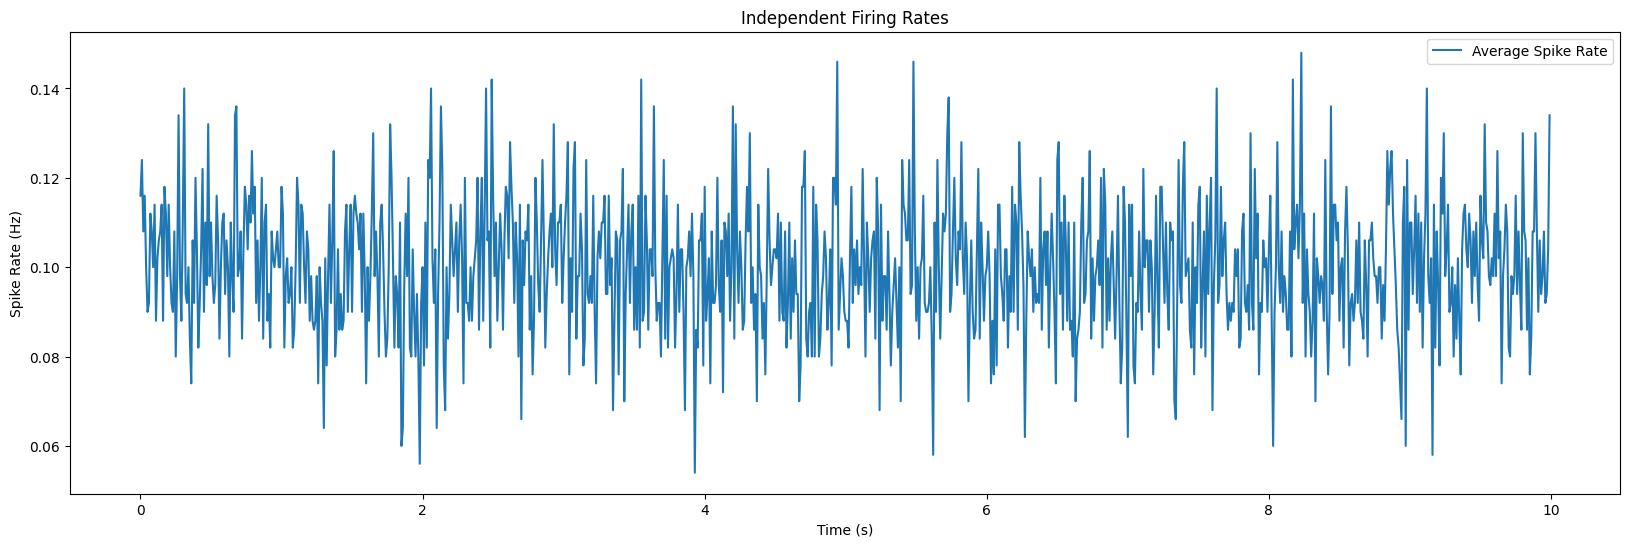

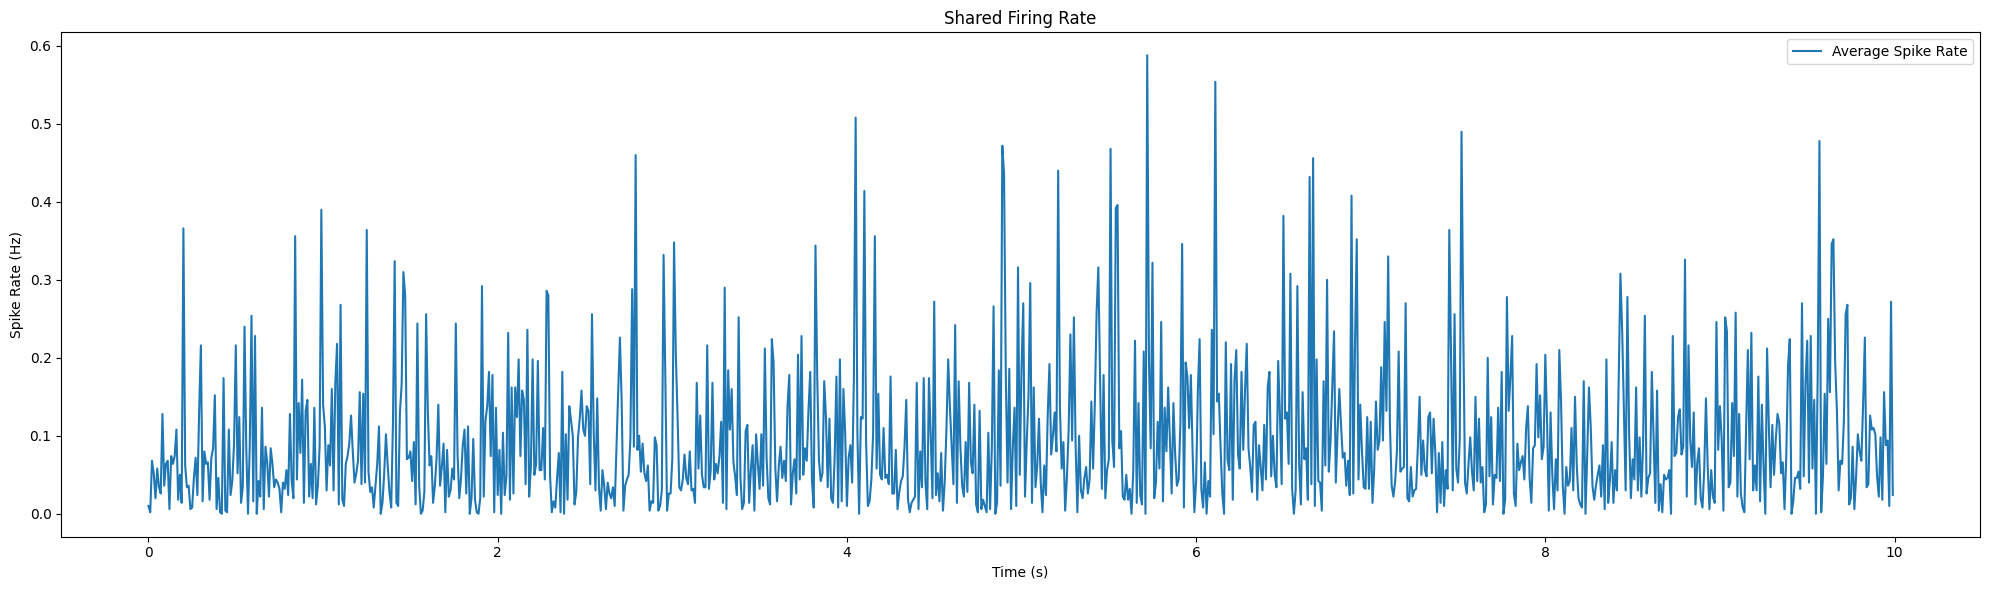

In [140]:
# Generate firing rates
firing_rates_independent = firing_rate_function_independent(time, num_neurons, r)
firing_rate_shared = firing_rate_function_shared(time, num_neurons, r)

# Count spikes in each time step
spike_counts_independent = np.sum(np.random.poisson(firing_rates_independent * 0.01), axis=0)
spike_counts_shared = np.sum(np.random.poisson(firing_rate_shared * 0.01), axis=0)

# Plot spike rates
plt.figure(figsize=(20, 6))

plt.plot(time, spike_counts_independent / num_neurons, label='Average Spike Rate')
plt.title('Independent Firing Rates')
plt.xlabel('Time (s)')
plt.ylabel('Spike Rate (Hz)')
plt.legend()
plt.show()

# plt.subplot(2, 1)
plt.figure(figsize=(20, 6))
plt.plot(time, spike_counts_shared / num_neurons, label='Average Spike Rate')
plt.title('Shared Firing Rate')
plt.xlabel('Time (s)')
plt.ylabel('Spike Rate (Hz)')
plt.legend()

plt.tight_layout()
plt.show()


To measure the avalanche sizes and find the probability we need to define a function. In the following I implement avalanche size duration and tried to plot the probability for each size

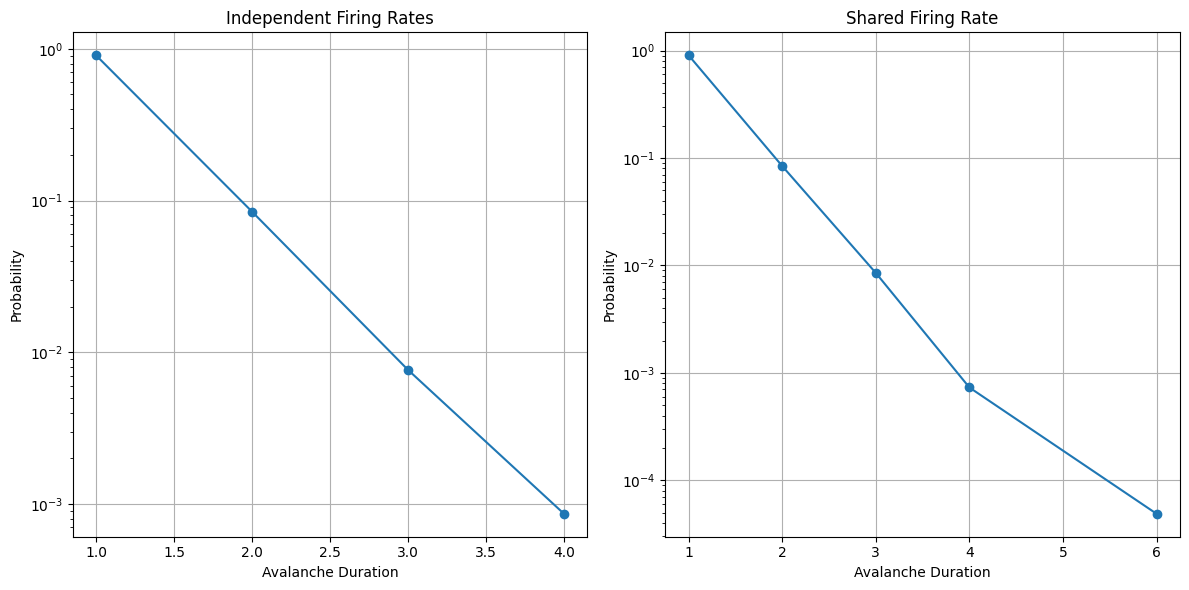

In [142]:
# Define avalacnche function 
def get_avalanche_durations(spike_train):
    intervals = np.diff(spike_train)
    durations = []
    current_duration = 1

    for interval in intervals:
        if interval == 1:
            current_duration += 1
        else:
            durations.append(current_duration)
            current_duration = 1

    durations.append(current_duration)
    return durations

# Define time vector
time = np.arange(0, 10, 0.01)  # 10 seconds with 0.01s time resolution

# Calculate avalanche durations for each neuron
durations_independent = [get_avalanche_durations(spike_train) for spike_train in spike_trains_independent]
durations_shared = [get_avalanche_durations(spike_train) for spike_train in spike_trains_shared]

# Combine all durations
all_durations_independent = np.concatenate(durations_independent)
all_durations_shared = np.concatenate(durations_shared)

# Plot the probability distribution of avalanche durations
plt.figure(figsize=(12, 6))

# Plot for Independent Firing Rates
plt.subplot(1, 2, 1)
counter_independent = Counter(all_durations_independent)
durations_unique_independent, counts_independent = zip(*sorted(counter_independent.items()))
probabilities_independent = np.array(counts_independent) / len(all_durations_independent)
plt.plot(durations_unique_independent, probabilities_independent, marker='o', linestyle='-')
plt.title('Independent Firing Rates')
plt.xlabel('Avalanche Duration')
plt.ylabel('Probability')
plt.yscale('log')
plt.grid(True)

# Plot for Shared Firing Rate
plt.subplot(1, 2, 2)
counter_shared = Counter(all_durations_shared)
durations_unique_shared, counts_shared = zip(*sorted(counter_shared.items()))
probabilities_shared = np.array(counts_shared) / len(all_durations_shared)
plt.plot(durations_unique_shared, probabilities_shared, marker='o', linestyle='-')
plt.title('Shared Firing Rate')
plt.xlabel('Avalanche Duration')
plt.ylabel('Probability')
plt.yscale('log')
plt.grid(True)

plt.tight_layout()
plt.show()
